<a href="https://colab.research.google.com/github/Musbell/Planta---Maize-disease-symptoms-detection/blob/master/Planta_Maize_disease_symptoms_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jul  7 18:15:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960     Off  | 00000000:01:00.0  On |                  N/A |
| 31%   47C    P2    25W / 120W |    546MiB /  1999MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

numpy      : 1.21.0
pandas     : 1.3.0
pycocotools: 2.0.2
torch      : 1.7.1
torchvision: 0.8.2
detectron2 : 0.4+cu101



In [3]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
setup_logger()

import onnx
from unittest.mock import MagicMock

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image


from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
from matplotlib import rc

torch.__version__
!gcc --version 

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
dataset_dir = './original_images/'

In [5]:
diseases_df = pd.read_csv('annotations_handheld.csv')

In [6]:
diseases_df.head()

,image,x1,y1,x2,y2,user,day,month,year,hour,minute
0,DSC00025.JPG,1864,2064,2864,1648,Tyr,26,5,2016,16,48
1,DSC00026.JPG,2872,1416,3152,2016,Tyr,26,5,2016,16,48
2,DSC00027.JPG,0,0,0,0,Tyr,5,10,2015,17,0
3,DSC00028.JPG,3248,1540,3572,2048,Tyr,26,5,2016,16,48
4,DSC00028.JPG,3444,1916,3852,2116,Tyr,26,5,2016,16,48


In [7]:
dataset = []


for index, row in tqdm(diseases_df.iterrows(), total=diseases_df.shape[0]):

    data = {}


    image_name = row['image']

    im = Image.open('{}{}'.format(dataset_dir, image_name))

    w, h = im.size

    data['file_name'] = image_name
    data['height'] = h
    data['width'] = w
    data["x_min"] = row["x1"]
    data["y_min"] = row["y1"]
    data["x_max"] = row["x2"]
    data["y_max"] = row["y2"]

    data['class_name'] = 'Northern Leaf Blight'

    dataset.append(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7699/7699 [00:03<00:00, 2067.21it/s]


In [8]:
df = pd.DataFrame(dataset)
df.head()

,file_name,height,width,x_min,y_min,x_max,y_max,class_name
0,DSC00025.JPG,4000,6000,1864,2064,2864,1648,Northern Leaf Blight
1,DSC00026.JPG,4000,6000,2872,1416,3152,2016,Northern Leaf Blight
2,DSC00027.JPG,4000,6000,0,0,0,0,Northern Leaf Blight
3,DSC00028.JPG,4000,6000,3248,1540,3572,2048,Northern Leaf Blight
4,DSC00028.JPG,4000,6000,3444,1916,3852,2116,Northern Leaf Blight


In [9]:
print(df.file_name.unique().shape[0], df.shape[0])

1787 7699


In [10]:
def annotate_image(annotations):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'{dataset_dir}/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 8)

    return img
  # if not resize:
  #   return img

  # return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

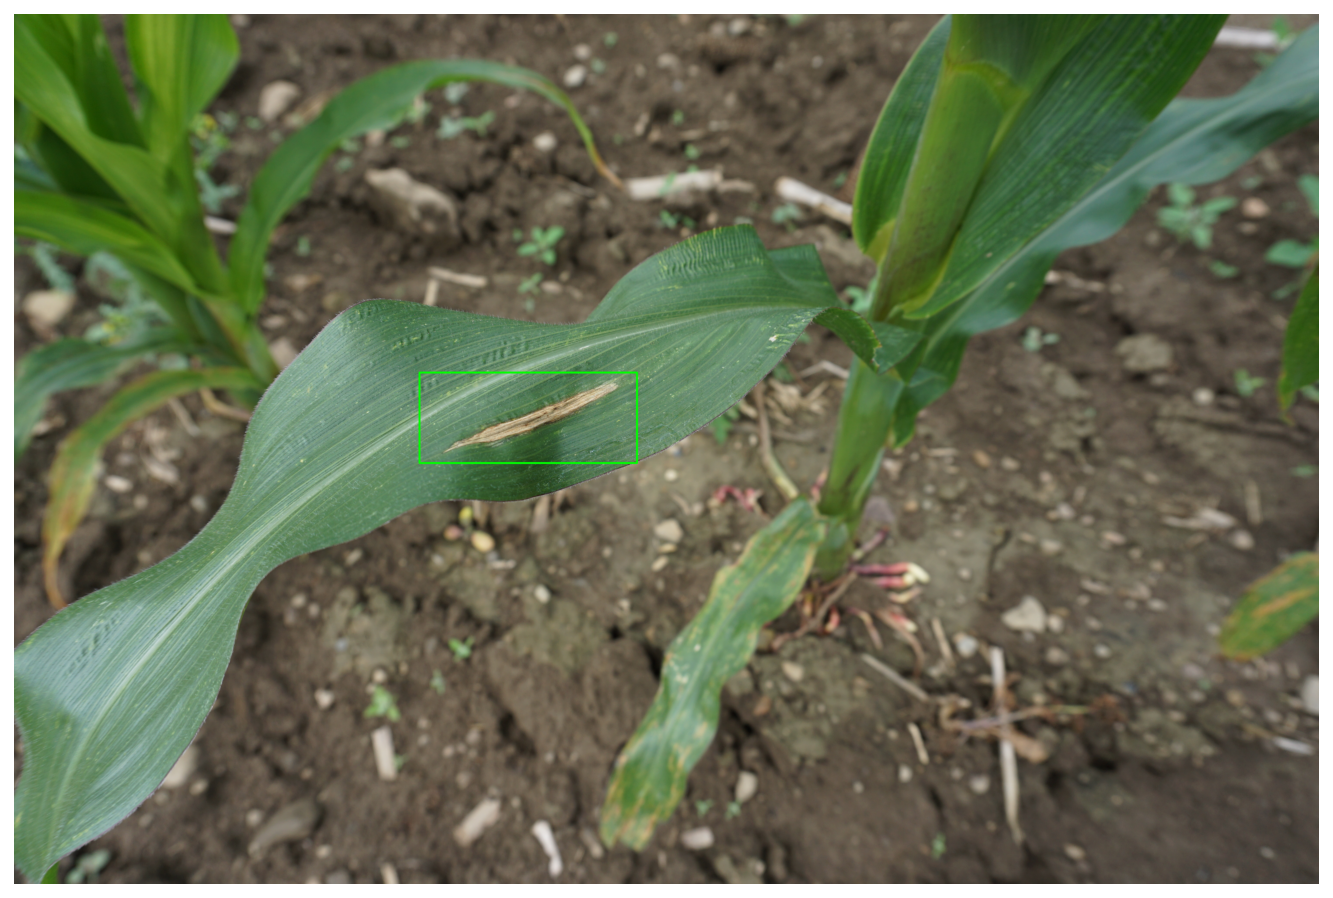

In [11]:
img_df = df[df.file_name == df.file_name.unique()[0]]
img = annotate_image(img_df)

plt.imshow(img)
plt.axis('off');

In [ ]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

In [ ]:
sample_images.shape

In [ ]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

In [ ]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

**Maize disease symptoms detection with Detectron2**

In [ ]:
df.to_csv(f'{dataset_dir}/annotations.csv', header=True, index=None)

In [ ]:
df = pd.read_csv(f'{dataset_dir}/annotations.csv')


IMAGES_PATH = f'{dataset_dir}'

unique_files = df.file_name.unique()

# will need to ensure that this is not random later on when comparing
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.80), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

In [ ]:
classes = df.class_name.unique().tolist()
print(classes)

In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}
    

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'

    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("diseases_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("diseases_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("diseases_train")

In [ ]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("./coco_eval", exist_ok=True)
        output_folder = "./coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
  )
)

cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/137260431/model_final_a54504.pkl"

In [ ]:
cfg.DATASETS.TRAIN = ("diseases_train",)
cfg.DATASETS.TEST = ("diseases_val",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.OUTPUT_DIR = './output'

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.STEPS = []     

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir output
# %tensorboard --logdir="./output"
!pip install 'tensorboard<2.4'

import sagemaker
sagemaker_session = sagemaker.Session()

print("SageMaker ver: " + sagemaker.__version__)

aws_region = sagemaker_session.boto_region_name

!AWS_REGION={aws_region} tensorboard --logdir="./output"

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
print(cfg.MODEL.WEIGHTS)

In [ ]:
cfg.dump()

In [ ]:
evaluator = COCOEvaluator("diseases_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "diseases_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

Find Diseases in the Images

In [ ]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [ ]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1.2, 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  #instances.
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

In [ ]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[230]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

Deployment

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.export import add_export_config, export_caffe2_model
from detectron2.modeling import build_model



# create a torch model
torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data
data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))

# convert and save caffe2 model
caffe2_model = export_caffe2_model(cfg, torch_model, first_batch)
caffe2_model.save_protobuf('./caffe2_model')
# draw the caffe2 graph
caffe2_model.save_graph(os.path.join('./caffe2_model', "model.svg"), inputs=first_batch)

# run evaluation with the converted model
if args.run_eval:
    dataset = cfg.DATASETS.TEST[0]
    data_loader = build_detection_test_loader(cfg, dataset)
    # NOTE: hard-coded evaluator. change to the evaluator for your dataset
    evaluator = COCOEvaluator(dataset, cfg, True, './caffe2_model')
    metrics = inference_on_dataset(caffe2_model, data_loader, evaluator)
    print_csv_format(metrics)